In [1]:
# Math import
import math
import numpy as np
import pandas as pd

# Graph import
import matplotlib.pyplot as plt
import matplotlib
# Use a more appealing style
matplotlib.style.use('ggplot')

# Plot in this notebook
%matplotlib inline

In [2]:
dataDir = "data/"

In [3]:
# Image resolution
width = 19.2
height = 10.8

# Multiplication of previous ones by dpi to have pixel resolution
dpi = 100 

### Get data

In [4]:
data = pd.read_json(dataDir + "paradox.json")
data.head()

,avgPlayers,gain,gameId,month,peakPlayers,percGain
0,NaN,None,236850,None,NaN,None
1,NaN,None,394360,None,NaN,None
2,13891.98,-2082.9,394360,Last 30 Days,25933.0,-13.04%
3,15974.93,4491.52,394360,March 2018,37055.0,+39.11%
4,11483.41,-186.89,394360,February 2018,21269.0,-1.60%


In [5]:
games = pd.read_csv(dataDir + "games.csv", sep=';')
games

,id,name
0,236850,Europa Universalis IV
1,203770,Crusader Kings 2
2,281990,Stellaris
3,394360,Hearts of Iron IV


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 6 columns):
avgPlayers     183 non-null float64
gain           183 non-null object
gameId         187 non-null int64
month          183 non-null object
peakPlayers    183 non-null float64
percGain       183 non-null object
dtypes: float64(2), int64(1), object(3)
memory usage: 8.8+ KB


### Cleaning

In [7]:
data = data[~pd.isnull(data["avgPlayers"])]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 2 to 186
Data columns (total 6 columns):
avgPlayers     183 non-null float64
gain           183 non-null object
gameId         183 non-null int64
month          183 non-null object
peakPlayers    183 non-null float64
percGain       183 non-null object
dtypes: float64(2), int64(1), object(3)
memory usage: 10.0+ KB


In [8]:
data = data[~data['month'].apply(lambda s : s.startswith("Last"))]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 3 to 186
Data columns (total 6 columns):
avgPlayers     179 non-null float64
gain           179 non-null object
gameId         179 non-null int64
month          179 non-null object
peakPlayers    179 non-null float64
percGain       179 non-null object
dtypes: float64(2), int64(1), object(3)
memory usage: 9.8+ KB


### Formatting

In [9]:
data["date"] = pd.to_datetime(data["month"], format='%B %Y')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 3 to 186
Data columns (total 7 columns):
avgPlayers     179 non-null float64
gain           179 non-null object
gameId         179 non-null int64
month          179 non-null object
peakPlayers    179 non-null float64
percGain       179 non-null object
date           179 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 11.2+ KB


In [10]:
if (data["gain"].dtype != 'float64'):
    data.loc[data["gain"] == '-', "gain"] = np.nan
    data["gain"] = pd.to_numeric(data["gain"])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 3 to 186
Data columns (total 7 columns):
avgPlayers     179 non-null float64
gain           175 non-null float64
gameId         179 non-null int64
month          179 non-null object
peakPlayers    179 non-null float64
percGain       179 non-null object
date           179 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 11.2+ KB


### Merging

In [11]:
mergedData = pd.merge(data, games, left_on='gameId', right_on='id')
del mergedData['id']
mergedData = mergedData.rename(index=str, columns={'name' : 'gameName'})
mergedData.head()

,avgPlayers,gain,gameId,month,peakPlayers,percGain,date,gameName
0,15974.93,4491.52,394360,March 2018,37055.0,+39.11%,2018-03-01,Hearts of Iron IV
1,11483.41,-186.89,394360,February 2018,21269.0,-1.60%,2018-02-01,Hearts of Iron IV
2,11670.30,494.75,394360,January 2018,20923.0,+4.43%,2018-01-01,Hearts of Iron IV
3,11175.55,704.68,394360,December 2017,19905.0,+6.73%,2017-12-01,Hearts of Iron IV
4,10470.87,756.15,394360,November 2017,19202.0,+7.78%,2017-11-01,Hearts of Iron IV


# Average player analysis

## All games

### Data extraction

In [13]:
avgPlayers = pd.DataFrame()
for gameId in mergedData['gameId'].unique():
    df = mergedData[mergedData['gameId'] == gameId]
    gameName = df['gameName'].unique()[0]
    dataCol = 'avgPlayers'
    avgPlayers = avgPlayers.join(df[['date', dataCol]].set_index('date').rename(index=str, columns={dataCol: gameName}), how='outer')

In [14]:
avgPlayers.tail()

,Hearts of Iron IV,Stellaris,Europa Universalis IV,Crusader Kings 2
date,,,,
2017-11-01 00:00:00,10470.87,8379.55,11658.68,4297.84
2017-12-01 00:00:00,11175.55,9548.79,11773.05,5217.52
2018-01-01 00:00:00,11670.30,11293.75,11326.08,4845.49
2018-02-01 00:00:00,11483.41,15954.27,10902.52,4448.83
2018-03-01 00:00:00,15974.93,17120.62,11802.87,3910.04


### Sorting according release date

In [31]:
releaseDate = list()
for col in avgPlayers.columns:
    releaseDate.append(avgPlayers.index[np.nonzero(avgPlayers[col] > 1000)[0][0]])

In [33]:
releaseDate

['2016-06-01 00:00:00',
 '2016-05-01 00:00:00',
 '2013-08-01 00:00:00',
 '2012-07-01 00:00:00']

In [35]:
indexReleaseDateOrder = sorted(range(len(releaseDate)), key=lambda k: releaseDate[k])
indexReleaseDateOrder

[3, 2, 1, 0]

In [37]:
avgPlayers = avgPlayers[avgPlayers.columns[indexReleaseDateOrder]]

### Visualization

<span style="color:red">WARNING : Like I have not succeed to heave beautiful ticks, I have hard coded them. So if you change the data, you need to change them (comment ax[1].set_xticklabels(hardCodedTicks) to know the new ticks)</span>

In [42]:
hardCodedTicks = ["Juillet 2012", "Mai 2013", "Mars 2014", "Janvier 2015", "Novembre 2015", "Septembre 2016", "Juillet 2017"]

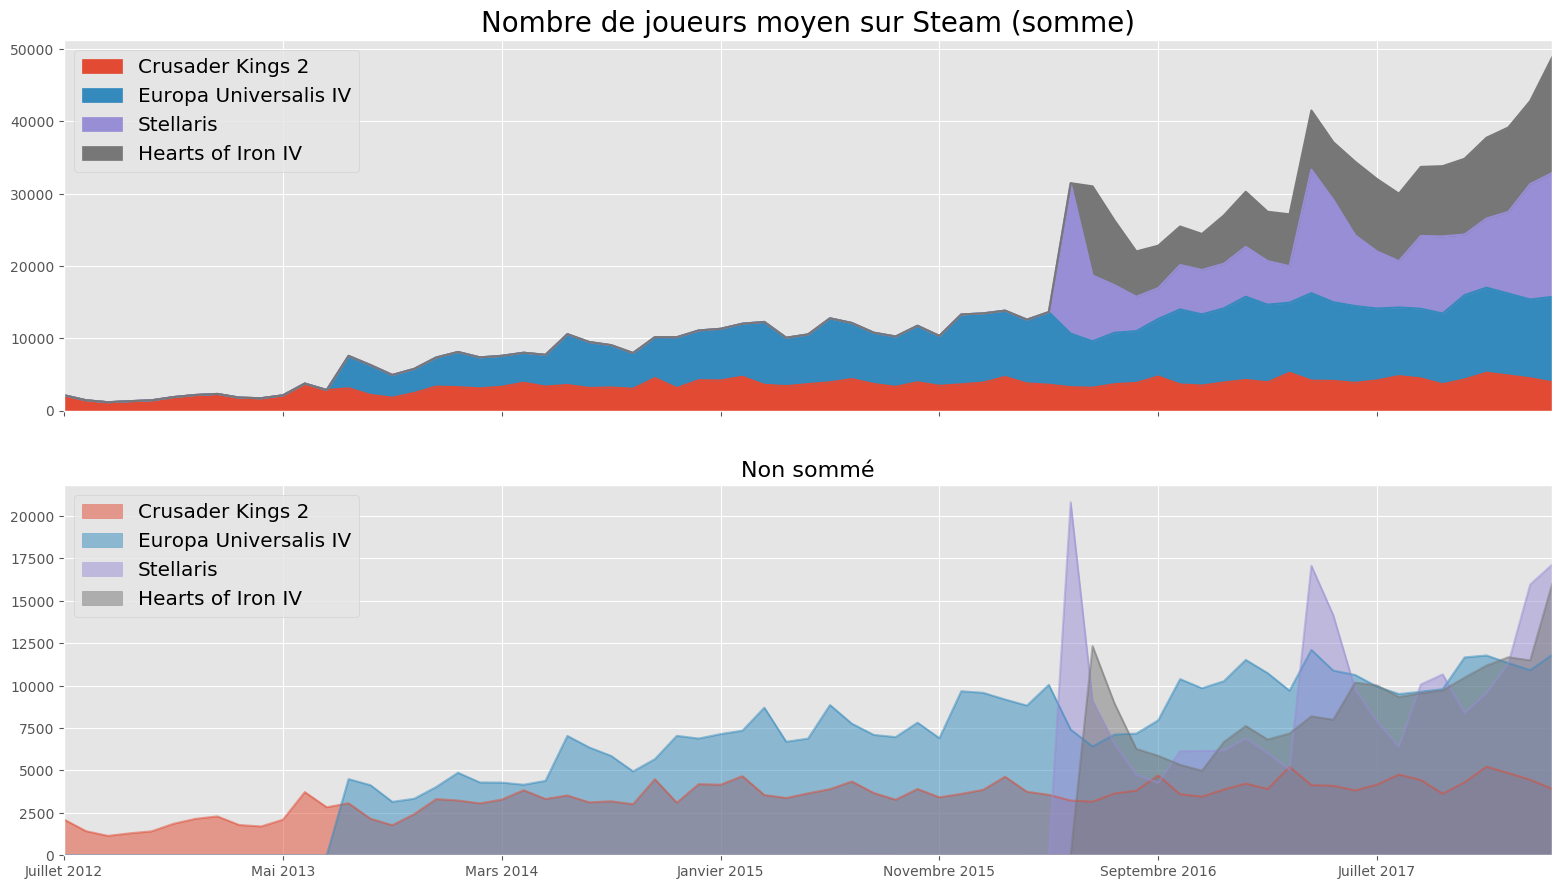

In [50]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(width, height), dpi=dpi, sharex=True)

ax[0].set_title("Nombre de joueurs moyen sur Steam (somme)", fontsize=20)
avgPlayers.plot.area(stacked=True, ax=ax[0])

ax[1].set_title(u"Non sommé", fontsize=16)
avgPlayers.plot.area(stacked=False, ax=ax[1])

ax[1].set_xlabel("")
ax[1].set_xticklabels(hardCodedTicks)

ax[0].legend(loc=2, fontsize = 'x-large')
ax[1].legend(loc=2, fontsize = 'x-large')

plt.savefig("Paradox average players.png", dpi=dpi)